In [1]:
from neural_network.nn_manager.TrainManager import TrainManager
from neural_network.store.DBNNSave import DBNNSave
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Conv2D, BatchNormalization, Merge
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as K
from random import shuffle
import h5py
import numpy as np
import tensorflow as tf
import keras

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
np.random.seed(7)

Using TensorFlow backend.


In [253]:
class retinaNN(TrainManager):
    def __init__(self):
        self.path_to_data = './data_icd6.hdf5'
        self.prepare_data(self.path_to_data)
        self.batch_size = 10
        self.epochs = 100
        self.example_images = []
        super(retinaNN, self).__init__()
        
        self.datagen_train = ImageDataGenerator(
            vertical_flip=True,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2,
            rotation_range = 30
        )
        
        self.datagen_val = ImageDataGenerator(
        )
        
    def prepare_data(self, path):
        hdf5_file = h5py.File(path, 'r')
        self.get_handlers(hdf5_file)
        self.load_sizes()
        
    def load_sizes(self):
        self.img_size_1 = self.X_train.shape[1]
        self.img_size_2 = self.X_train.shape[2]
        self.outputs_size = self.Y_train.shape[1]
        self.num_train_samples = self.X_train.shape[0]
        self.num_val_samples = self.X_val.shape[0]
        self.num_test_samples = self.X_test.shape[0]
    
    def get_handlers(self, file):
        self.X_train = file['train_data_x']
        self.X_train_medic = file['train_data_medic']
        self.Y_train = file['train_data_y']
        self.X_val = file['val_data_x']
        self.X_val_medic = file['val_data_medic']
        self.Y_val = file['val_data_y']
        self.X_test = file['test_data_x']
        self.Y_test = file['test_data_y']
        self.X_test_medic = file['test_data_medic']
    
    def store_method(self):
        return DBNNSave()

    def train_data_generator(self):
        generator = self._generator(self.X_train,  self.X_train_medic, self.Y_train, self.datagen_train)
        return generator

    def test_data_generator(self):
        generator = self._generator(self.X_val, self.X_train_medic, self.Y_val, self.datagen_val)
        return generator

    def create_model(self):
        input_image = Input(shape=(self.img_size_1, self.img_size_2, 3))
        input_med = Input(shape=(93,))

        layer = Conv2D(filters=32, kernel_size=(3, 3))(input_image)
        layer = BatchNormalization(axis=1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Conv2D(filters=32, kernel_size=(3, 3))(input_image)
        layer = BatchNormalization(axis=1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Flatten()(layer)
        
        merge = keras.layers.concatenate([layer, input_med])
        layer = Dense(9)(merge)
        #layer = Dense(9)(layer)
        layer = BatchNormalization(axis=1)(layer)
        output_layer = Activation('softmax')(layer)
        model = Model(inputs=[input_image,input_med], outputs=output_layer)
        #model = Model(inputs=[input_image], outputs=output_layer)
        model.compile( optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['acc'])
        return model

    def f1_score(self, y_true, y_pred):
        c1 = self.get_true_positive(y_true,y_pred)
        c2 = self.get_positive_pred(y_pred)
        c3 = self.get_positive_true(y_true)

        if c3 == 0:
            return 0

        precision = c1 / c2
        recall = c1 / c3
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score
    
    def precision(self,y_true,y_pred):
        c1 = self.get_true_positive(y_true,y_pred)
        c2 = self.get_positive_pred(y_pred)
        return c1/c2
    
    def recall(self,y_true,y_pred):
        c1 = self.get_true_positive(y_true,y_pred)
        c3 = self.get_positive_true(y_true)
        return c1/c3
    
    def get_true_positive(self,y_true,y_pred):
        return K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    def get_positive_pred(self,y_pred):
        return K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    def get_positive_true(self,y_true):
        return K.sum(K.round(K.clip(y_true, 0, 1)))
    
    def _generator(self,X,X_medic,Y,datagen):       
        while 1:
            batch_s = self.batch_size
            for i in range(X.shape[0] // self.batch_size):
                x_part1 = X[i*batch_s: (i+1)*batch_s]
                x_part2 = X_medic[i*batch_s: (i+1)*batch_s]
                y_part = Y[i*batch_s: (i+1)*batch_s]
                #yield x_part1, y_part
                yield [x_part1,x_part2], y_part
        
    def train(self):
        return self.train_model(
            self.num_train_samples // self.batch_size,
            self.num_val_samples // self.batch_size,
            epochs=self.epochs
        )

In [257]:
retina = retinaNN()
print(len(retina.X_train))
print(len(retina.X_val))
print(len(retina.X_test))


#history = retina.train()
retina.model.load_weights('w2.h5')

180
60
57


In [47]:
def get_model_quality(y_true,y_pred):
    c1 = sum(np.around(y_true*y_pred)) #TP
    c2 = sum(np.around(y_pred))
    c3 = sum(np.around(y_true))
    precision = c1/c2
    recall = c1 / c3
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

yt = []
ys = []
for i in range(15):
    x_test = retina.X_test[i:i+1]
    x_test_medic = retina.X_test_medic[i:i+1]
    y_test = retina.Y_test[i]
    yt.append(y_test)
    #y_score = retina.model.predict([x_test,x_test_medic])
    y_score = retina.model.predict(x_test)
    print(y_score[0])
    print(y_test)
    prec, recall, _ = get_model_quality(y_test,y_score[0])
    print(prec, recall)
    
    
generate_results(yt,ys)


[ 0.01164967  0.02855273  0.02514034  0.01603949  0.01810054  0.16815706
  0.67357123  0.03013354  0.02865546]
[0 0 0 0 0 0 1 0 0]
1.0 1.0
[ 0.09186152  0.05030286  0.02656964  0.0671965   0.06740545  0.12259051
  0.48392028  0.04704923  0.04310394]
[0 0 0 0 0 1 0 0 0]
nan 0.0


C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


ValueError: multiclass-multioutput format is not supported

In [38]:
yt = []
ys = []
x_test = retina.X_test
x_test_medic = retina.X_test_medic
y_test = retina.Y_test
y_score = retina.model.predict(x_test)
print(y_score)
generate_results(y_test,y_score[0])


[[ 0.01164966  0.02855254  0.02514021  0.01603944  0.01810044  0.16815695
   0.67357206  0.03013336  0.02865537]
 [ 0.09186133  0.05030276  0.02656974  0.06719641  0.06740575  0.12259062
   0.48392001  0.04704921  0.04310413]
 [ 0.04742068  0.02903544  0.02779812  0.02785941  0.04073948  0.0668308
   0.70453209  0.02849566  0.02728822]
 [ 0.01068427  0.03536986  0.04499243  0.03065041  0.02861526  0.17263149
   0.6121363   0.03364987  0.03127014]
 [ 0.04803813  0.06166513  0.02438576  0.0615518   0.05194494  0.271299
   0.39165384  0.04594425  0.04351713]
 [ 0.01496305  0.03464977  0.03007491  0.03892701  0.01925949  0.11550692
   0.6874752   0.02844616  0.03069746]
 [ 0.01365276  0.03416675  0.03394854  0.03955381  0.04453529  0.07960218
   0.67965275  0.03962142  0.03526649]
 [ 0.01227994  0.01326199  0.01530045  0.01571426  0.01184579  0.0149384
   0.88870931  0.01434783  0.01360191]
 [ 0.03697824  0.04194755  0.03848983  0.03819505  0.05928475  0.37477732
   0.34169155  0.03465567 

ValueError: multilabel-indicator format is not supported

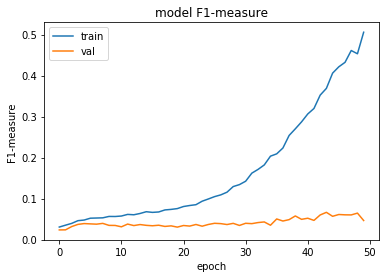

In [9]:
import matplotlib.pyplot as plt
# x = np.arange(50)
# plt.plot(x,history.history['precision'])
# plt.plot(x,history.history['val_precision'])
# #plt.plot(x,accf)
# #plt.plot(x,val_accf)
# plt.title('model precision')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['recall'])
# plt.plot(history.history['val_recall'])
# #plt.plot(x,lossf)
# #plt.plot(x,val_lossf)
# plt.title('model recall')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
#plt.plot(x,lossf)
#plt.plot(x,val_lossf)
plt.title('model F1-measure')
plt.ylabel('F1-measure')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('f1.png')
plt.show()

In [268]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
def change_y_to_words(y,index):
    hdf5_file = h5py.File(retina.path_to_data, 'r')
    n_gram = hdf5_file.attrs['n_gram']
    predicted_words = []
    for i in range(len(y)):
        if y[i] > 0.70:
            print(index)
            predicted_words.append(tuple(n_gram[i]))
    return predicted_words

def get_model_quality(y_true,y_pred):
    c1 = sum(np.around(y_true*y_pred)) #TP
    c2 = sum(np.around(y_pred))
    c3 = sum(np.around(y_true))
    precision = c1/c2
    recall = c1 / c3
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

w = len(retina.Y_test[0])
h = retina.Y_test.shape[0]
pred_y = [[0 for i in range(h)] for j in range(w)]
true_y = [[0 for i in range(h)] for j in range(w)]
print(len(pred_y))
def test_model():
    for i in range(0,57):
        x_test = retina.X_val[i:i+1]
        x2_test = retina.X_val_medic[i:i+1]
        y_test = retina.Y_val[i]
        y_score = retina.model.predict([x_test,x2_test])
        c = []
        e = np.argmax(y_score[0])
        #print(y_score)
        #print(y_score[0][e])
        #print(e)
        y_score[0][e] = 1
        
        for j in range(len(y_test)):
            true_y[j][i] = y_test[j]
            #true_y[j][i] = y_score[0][j]
            d = 0
            if y_score[0][j] > 0.5:
                c.append(1)
                d = 1
            else:
                d = 0
                c.append(0)
            pred_y[j][i] = d#y_score[0][j]
        #print(y_test)
        precision, recall, f1_score = get_model_quality(y_test,y_score[0])
        #print(c)
        #print(precision,recall,f1_score)
        #print(change_y_to_words(y_score[0],i))
    
    aucs = []
    for i in range(len(true_y)):
        #print(true_y[0])
        #print(pred_y[0])
        #prec, rec, _ = get_model_quality(np.array(pred_y[i]),np.array(true_y[i]))
        #print(prec)
        #print(rec)
        #print()
        #print(true_y[i])
        #print(pred_y[i])
        #accuracy = accuracy_score(true_y[i],pred_y[i])
        #print(accuracy)
        print(sum(np.around(np.array(true_y[i])*np.array(pred_y[i])))/sum(np.array(true_y[i])))
        #print(true_y[i])
        #pass
        #print(pred_y[i])
        #roc_auc = generate_results(true_y[i],pred_y[i])
        #aucs.append(roc_auc)
    
    print(np.nanmean(aucs))
test_model()

9


C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


nan
nan
nan
nan
0.0
0.4375
0.820512820513
nan
nan
nan


C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice


In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def generate_results(y_test, y_score, plot=False):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    print(fpr,tpr)
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.show()
    print('AUC: %f' % roc_auc)
    return roc_auc


In [14]:
f = h5py.File('./data_s100.hdf5', 'r')
print(f['test_data_metadata/45'])
for k, v in f['train_data_metadata/27'].items():
    print(k,v.value)

<HDF5 group "/test_data_metadata/45" (6 members)>
examination_id 109
first 4372
last 4379
middle 4376
series 425
side R


In [16]:
import PIL
from text_processing.NGramCounter import NGramCounter
from text_processing.NGramVectorBuilder import NGramVectorBuilder
from data_module.models import Image as Retina_Image
from data_module.models import Person, Examination, Description, ImageSeries, ProcessedDescription
def get_ngram_vector_builder():
    n = 2; outputs = 1000; limit = 0
    ngc = NGramCounter()
    n_gram = ngc.get_n_gram_histogram(n,limit,outputs)
    return NGramVectorBuilder(n_gram), n_gram

i = Retina_Image.objects.get(id=2092)
img = PIL.Image.open(i.image)
#img.show()

desc = ProcessedDescription.objects.get(id=7)
print(desc.text)
iss = ImageSeries.objects.get(id=6)
e = iss.examination
print(e.person.code_name)
nGramVbuild,n_gram = get_ngram_vector_builder()
words_vector = nGramVbuild.get_vector(290, 'R')
#print(words_vector)
#print(n_gram)
n_gram = list(dict(n_gram))
#print(n_gram)
for i in range(len(words_vector)):
    if(words_vector[i] == 1):
        print(n_gram[i])
#print(n_gram)




ukazować faza mieszany ognisko hipofluorescencja odpowiadać wybroczyna krwotoczki ognisko hiperfluorescencja odpowiadać mikroaneuryzmaty faza późny obrzęk siatkówka masywny wzdłuż arkada torbielowaty dochodzić plamka obwód początkowy zmiana naczyniowy tworzyć strefa awaskularne
D_00e72bbf43229b7e7eed9816f658f20c


In [82]:
for i in range(0,10):
    w = f['train_data_metadata/'+str(i)+'/series'].value
    s = f['train_data_metadata/'+str(i)+'/side'].value      
    words_vector = nGramVbuild.get_vector(w, s)
    for j in range(len(words_vector)):
        if(words_vector[j] == 1):
            print(n_gram[j],i)
            
print(f['train_data_metadata/1/series'].value)

('wszyscy', 'faza') 0
('faza', 'angiogram') 0
('angiogram', 'widoczny') 0
('brak', 'cech') 0
('badan', 'soct') 0
('wskazany', 'uzupełnienie') 0
('uzupełnienie', 'diagnostyk') 0
('tło', 'naczyniówkowy') 0
('diagnostyk', 'badan') 0
('widoczny', 'hiperfluorescencja') 0
('cech', 'patologiczny') 0
('soct', 'cel') 0
('patologiczny', 'fluorescencja') 0
('zcieńczenia', 'warstwa') 0
('fluorescencja', 'tło') 0
('kwalifikacja', 'terapia') 0
('warstwa', 'rpe') 0
('rpe', 'brak') 0
('hiperfluorescencja', 'tło') 0
('faza', 'późny') 5
('faza', 'wczesny') 5
('plamisty', 'hiperfluorescencja') 5
('faza', 'kolejny') 5
('swoić', 'intensywność') 5
('intensywność', 'faza') 5
('późny', 'widoczny') 5
('hiperfluorescencja', 'zwiększać') 5
('kolejny', 'faza') 5
('badanie', 'poprzedni') 5
('widoczny', 'wyraźnie') 5
('jak', 'badanie') 5
('hiperfluorescencja', 'powodować') 5
('obraz', 'jak') 5
('powodować', 'obecność') 5
('obecność', 'blizna') 5
('nieznacznie', 'swoić') 5
('wczesny', 'plamisty') 5
('ukazować', 'faz

In [21]:
i = Retina_Image.objects.get(id=4379)
img = PIL.Image.open(i.image)
img.save('i3.png')

In [234]:
a = [0,0,0, 1, 0]
b = [0,0,0, 0.001,1]
generate_results(a,b)

[ 0.    0.25  0.25  1.  ] [ 0.  0.  1.  1.]
AUC: 0.750000


0.75